In [250]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import sunpy
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.sun import constants as const
from sunkit_instruments import suvi
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, LogStretch, PercentileInterval

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [3]:
def load_suvi(start=None, end=None, channel=195):
    """
    * 9.4 nm (FeXVIII)
    * 13.1 nm (FeXXI)
    * 17.1 nm (FeIX/X)
    * 19.5 nm (FeXII)
    * 28.4 nm (FeXV)
    * 30.4 nm (HeII)
    """
    dt_dict = split_datetime(start=start, end=end)
    data_path = f"{data_dir}/SUVI/{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}/{channel}A"
    root_filename = f"dr_suvi-l2-ci{channel}_g18_s"
    data = sorted(glob.glob(f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.fits"))
    
    start_file_to_find = f"{data_path}/{root_filename}{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0000Z_e{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}0400Z_v1-0-2.fits"
    end_file_to_find   = f"{data_path}/{root_filename}{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}2800Z_e{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}3200Z_v1-0-2.fits"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = suvi.files_to_map(file, despike_l1b=True)
        min_range = 0
        if channel == 94:
            max_range = 20
        elif channel == 171:
            max_range = 20
        elif channel == 131:
            max_range = 20
        elif channel == 195:
            max_range = 50
        elif channel == 284:
            max_range = 50
        elif channel == 304:
            max_range = 100
        
        m.plot_settings['norm'] = ImageNormalize(vmin=min_range, vmax=max_range, stretch=LogStretch())
        map_objects.append(m)
        print(f'SUVI image {i} is done')
    return map_objects



def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 and C3 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects



def split_datetime(start=None, end=None):
    
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict




def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps, vmin=0, vmax=2):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs:
            - list of EUV sunpy maps.
            - range of the clipping threshold.
        Output:
            - sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=vmin, vmax=vmax)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax

In [4]:
suvi_map_objects  = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T18:00:00', channel=195)
clean_suvi_maps   = remove_redundant_maps(suvi_map_objects)
suvi_seq_runratio = apply_runratio(clean_suvi_maps)

for m in suvi_seq_runratio:
    m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


In [5]:
# # Test ...
# m = suvi_seq_runratio[5]

# fig = plt.figure()
# ax = fig.add_subplot(projection=m)
# img = m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# plt.colorbar(img, pad=0.02, shrink=0.8)
# plt.show()

In [6]:
# subset_suvi = [ suvi_seq_runratio[7], suvi_seq_runratio[6], suvi_seq_runratio[5] ]

# fig = plt.figure(figsize=[13,5])

# for i, m_suvi in enumerate(subset_suvi):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_suvi)
#     m_suvi.plot(axes=ax)
#     m_suvi.draw_limb()
#     ax.grid(False)
    
#     if i == 1 or i == 2:
#         ax.set_ylabel(' ')
#         ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
# plt.show()

In [7]:
lasco_c2_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C2')

# remove redundant images
clean_maps_c2 = remove_redundant_maps(lasco_c2_map_objects)

print(f'Before:\nLASCO C2: {len(lasco_c2_map_objects)} images\n')
print(f'After:\nLASCO C2: {len(clean_maps_c2)} images')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

2025-03-20 15:57:38 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:57:44 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


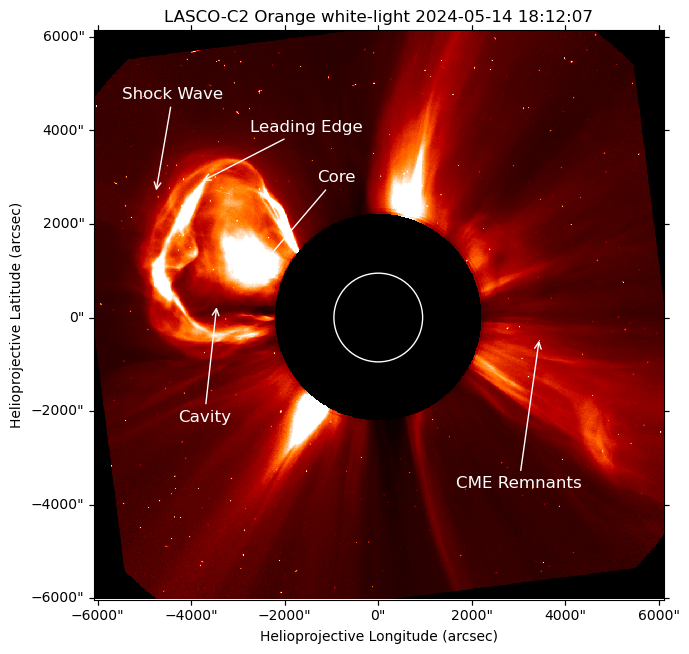

In [8]:
# Test ...
m = clean_maps_c2[4]

fig = plt.figure(figsize=[7,7], layout='constrained')
ax = fig.add_subplot(projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
ax.set_xlabel('Helioprojective Longitude (arcsec)')
ax.set_ylabel('Helioprojective Latitude (arcsec)')

ax.annotate('Core', xy=(300, 600), xytext=(400, 750),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('Cavity', xy=(220, 530), xytext=(150, 320),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('Leading Edge', xy=(190, 750), xytext=(280, 840),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('Shock Wave', xy=(110, 730), xytext=(50, 900),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

ax.annotate('CME Remnants', xy=(800, 470), xytext=(650, 200),
            # arrowprops=dict(facecolor='white', shrink=0.05),
            arrowprops=dict(arrowstyle='->', color='white', lw=1),
            color='white', fontsize=12)

fig.tight_layout()
# fig.savefig(f'{data_dir}/c2_whitelight.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [9]:
# subset_c2 = clean_maps_c2[2:5][::-1]

# fig = plt.figure(figsize=[13,5])

# for i, m_c2 in enumerate(subset_c2):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c2)
#     m_c2.plot(axes=ax)
#     m_c2.draw_limb()
#     ax.grid(False)

# fig.tight_layout()
# plt.show()

In [10]:
# make run-diff maps
m_seq_runratio_c2 = apply_runratio(clean_maps_c2)

In [11]:
# # Test ...
# m_c2_rr = m_seq_runratio_c2[2]

# fig = plt.figure()
# ax = fig.add_subplot(projection=m_c2_rr)
# img = m_c2_rr.plot(axes=ax)
# m_c2_rr.draw_limb()
# ax.grid(False)
# plt.colorbar(img, pad=0.02, shrink=0.8)
# plt.show()

In [12]:
# subset_runratio_c2 = [ m_seq_runratio_c2[3], m_seq_runratio_c2[2], m_seq_runratio_c2[1] ]

# fig = plt.figure(figsize=[13,5])

# for i, m_c2 in enumerate(subset_runratio_c2):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c2)
#     m_c2.plot(axes=ax)
#     m_c2.draw_limb()
#     ax.grid(False)
#     ax.set_title(m_c2.latex_name.replace('Orange white-light ', ''))
    
#     if i == 1 or i == 2:
#         ax.set_ylabel(' ')
#         ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
# plt.show()

In [13]:
lasco_c3_map_objects = load_lasco(start='2024-05-14T17:45:00', end='2024-05-14T23:59:59', detector='C3')

LASCO C3 image 0 is done
LASCO C3 image 1 is done
LASCO C3 image 2 is done
LASCO C3 image 3 is done
LASCO C3 image 4 is done
LASCO C3 image 5 is done
LASCO C3 image 6 is done
LASCO C3 image 7 is done
LASCO C3 image 8 is done
LASCO C3 image 9 is done
LASCO C3 image 10 is done
LASCO C3 image 11 is done
LASCO C3 image 12 is done
LASCO C3 image 13 is done
LASCO C3 image 14 is done
LASCO C3 image 15 is done
LASCO C3 image 16 is done
LASCO C3 image 17 is done
LASCO C3 image 18 is done
LASCO C3 image 19 is done
LASCO C3 image 20 is done
LASCO C3 image 21 is done
LASCO C3 image 22 is done
LASCO C3 image 23 is done
LASCO C3 image 24 is done
LASCO C3 image 25 is done
LASCO C3 image 26 is done
LASCO C3 image 27 is done
LASCO C3 image 28 is done
LASCO C3 image 29 is done
LASCO C3 image 30 is done
LASCO C3 image 31 is done
LASCO C3 image 32 is done
LASCO C3 image 33 is done
LASCO C3 image 34 is done
LASCO C3 image 35 is done
LASCO C3 image 36 is done
LASCO C3 image 37 is done
LASCO C3 image 38 is d

In [14]:
# remove redundant images
clean_maps_c3 = remove_redundant_maps(lasco_c3_map_objects)

print(f'Before:\nLASCO C3: {len(lasco_c3_map_objects)} images\n')
print(f'After:\nLASCO C3: {len(clean_maps_c3)} images')

Before:
LASCO C3: 374 images

After:
LASCO C3: 29 images


In [15]:
# make run-diff maps
m_seq_runratio_c3 = apply_runratio(clean_maps_c3, vmin=0.6, vmax=1.4)

In [16]:
# # Test ...
# m = clean_maps_c3[13]

# fig = plt.figure()
# ax = fig.add_subplot(projection=m)
# img = m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [17]:
# # Take 3 items starting from index 3, skipping n items in between
# # subset_c3 = clean_maps_c3[3:3 + 3*3:3][::-1]
# subset_c3 = clean_maps_c3[3:][::5][:3][::-1]

# fig = plt.figure(figsize=[15,5])

# for i, m_c3 in enumerate(subset_c3):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c3)
#     m_c3.plot(axes=ax)
#     m_c3.draw_limb()
#     ax.grid(False)
#     print(m_c3.meta['time_obs'])

# fig.tight_layout()
# plt.show()

In [18]:
# subset_runratio_c3 = [ m_seq_runratio_c3[12], m_seq_runratio_c3[7], m_seq_runratio_c3[2] ]

# fig = plt.figure(figsize=[15,5])

# for i, m_c3 in enumerate(subset_runratio_c3):
#     ax = fig.add_subplot(1, 3, i+1, projection=m_c3)
#     m_c3.plot(axes=ax)
#     m_c3.draw_limb()
#     ax.grid(False)

# fig.tight_layout()
# plt.show()

2025-03-20 15:59:03 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:04 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:05 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:05 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:05 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-20 15:59:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-20 15:59:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


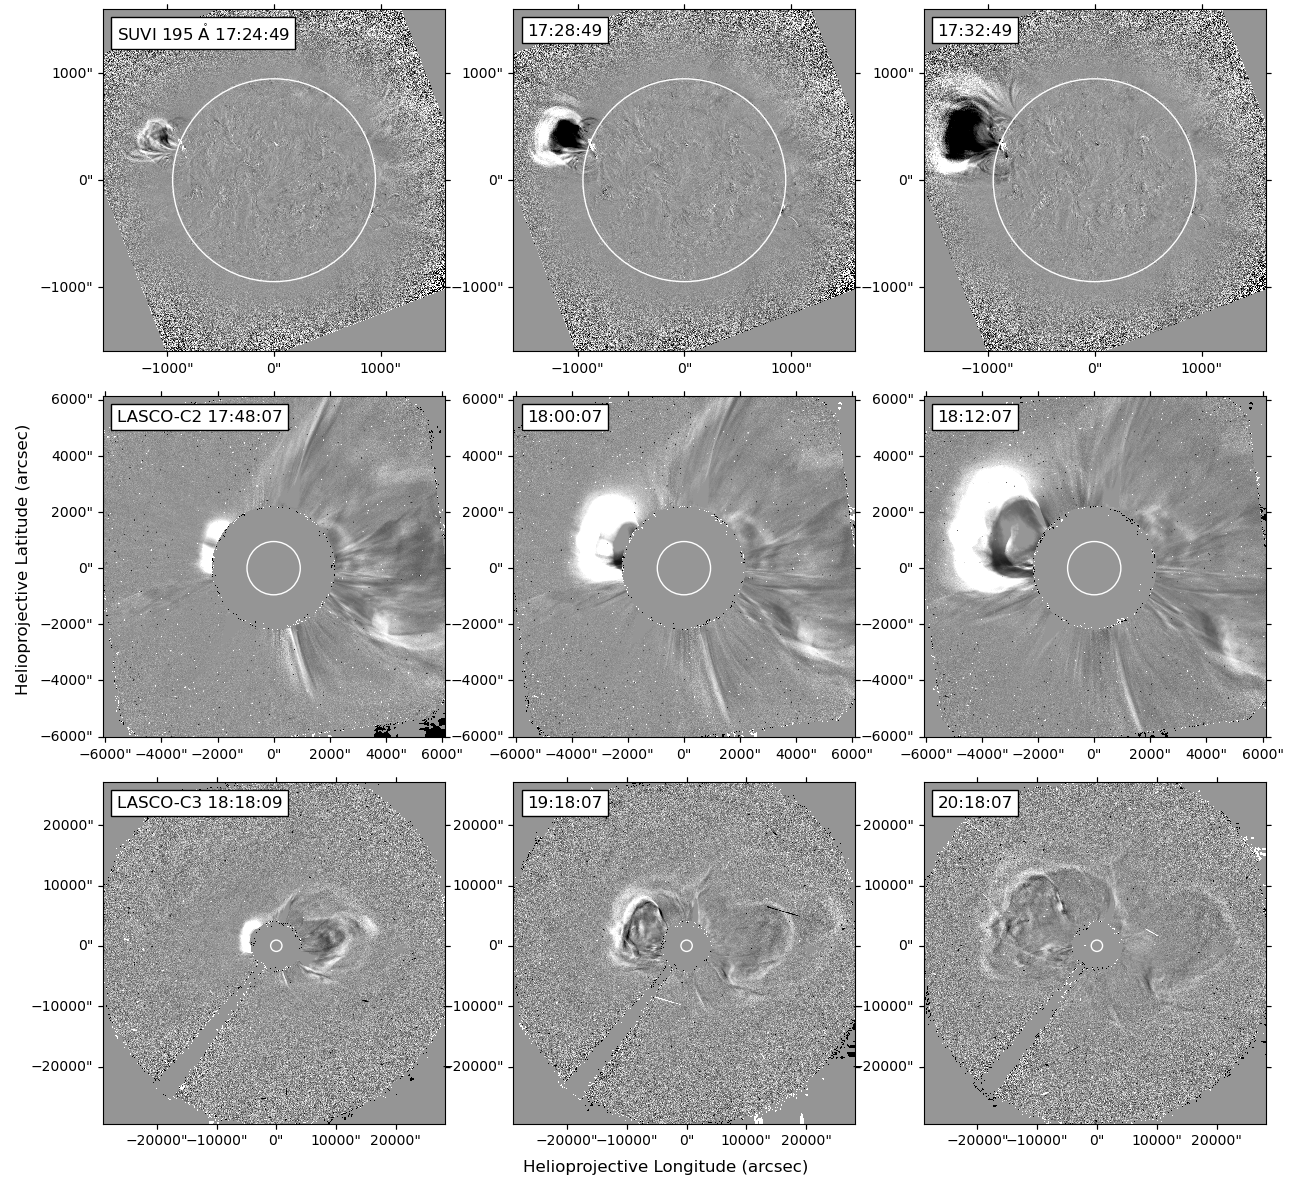

In [19]:
subset = [ suvi_seq_runratio[5], suvi_seq_runratio[6], suvi_seq_runratio[7], 
          m_seq_runratio_c2[1], m_seq_runratio_c2[2], m_seq_runratio_c2[3], 
          m_seq_runratio_c3[2], m_seq_runratio_c3[7], m_seq_runratio_c3[12] ]

# fig = plt.figure(figsize=[15,15], layout='constrained')
fig = plt.figure(figsize=[15,15])
fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.09)
fig.supylabel('Helioprojective Latitude (arcsec)', x=0.067)

for i, m in enumerate(subset):
    ax = fig.add_subplot(3, 3, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_limb()
    ax.grid(False)
    ax.set_title('')
    
    if i==0:
        label = m.latex_name.split(' 2024')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==1 or i==2:
        label = m.latex_name.split('2024-05-14 ')[-1]
    elif i==3:
        label = m.latex_name.split(' Orange')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==4 or i==5:
        label = m.latex_name.split('2024-05-14 ')[-1]
    elif i==6:
        label = m.latex_name.split(' Clear')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==7 or i==8:
        label = m.latex_name.split('2024-05-14 ')[-1]
    
    ax.text(0.04, 0.96, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    # ax.text(0.03, 0.955, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    # ax.text(0.025, 0.05, m.latex_name, horizontalalignment='left', color='k',
    #         verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
    
    # if 'SUVI' in m.latex_name:
    #     ax.set_title(m.latex_name.replace('2024-05-14 ', ''))
    # elif 'LASCO-C2' in m.latex_name:
    #     ax.set_title(m.latex_name.replace('Orange white-light 2024-05-14 ', ''))
    # elif 'LASCO-C3' in m.latex_name:
    #     ax.set_title(m.latex_name.replace('Clear white-light 2024-05-14', ''))
    
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    # # hide tick labels
    # if i==0 or i==3:
    #     ax.coords[0].set_ticklabel_visible(False)
    # elif i==7 or i==8:
    #     ax.coords[1].set_ticklabel_visible(False)
    # elif i==1 or i==2 or i==4 or i==5:
    #     ax.coords[0].set_ticklabel_visible(False)
    #     ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.01)  # Reduce whitespace
# fig.savefig(f'{data_dir}/euv_runratio_panels.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [20]:
# clean_suvi_maps
# clean_maps_c2
# clean_maps_c3

In [21]:
# for m in clean_suvi_maps:
#     print(m.meta['date-obs'])

### Est. the CME expansion speed

In [187]:
# value = 160 # central line (Geometric angle = 160 deg. --> PA = 70 deg.)

# fig = plt.figure(figsize=[15,5])
# fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.07)
# fig.supylabel('Helioprojective Latitude (arcsec)', x=0.03)

# m = m_seq_runratio_c2[1]
# ax = fig.add_subplot(131, projection=m)
# m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# ax.set_xlabel(' ')
# ax.set_title('')
# label = m.latex_name.split(' Orange')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
# ax.text(0.04, 0.96, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
# ax.set_xlabel(' ')
# ax.set_ylabel(' ')
# upper_line   = myfuncs.plot_line(angle_deg=value-27, length=3300, map_obj=m)
# central_line = myfuncs.plot_line(angle_deg=value, length=3000, map_obj=m) # plot a line in the center of the CME
# lower_line   = myfuncs.plot_line(angle_deg=value+27, length=3300, map_obj=m)
# ax.plot_coord(upper_line, color='black')
# ax.plot_coord(central_line, color='black')
# ax.plot_coord(lower_line, color='black')

# m = m_seq_runratio_c2[2]
# ax = fig.add_subplot(132, projection=m)
# m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# ax.set_ylabel(' ')
# ax.set_title('')
# label = m.latex_name.split('2024-05-14 ')[-1]
# ax.text(0.04, 0.96, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
# ax.set_xlabel(' ')
# ax.set_ylabel(' ')
# upper_line   = myfuncs.plot_line(angle_deg=value, length=5400, map_obj=m)
# central_line = myfuncs.plot_line(angle_deg=value, length=5400, map_obj=m) # plot a line in the center of the CME
# lower_line   = myfuncs.plot_line(angle_deg=value, length=5400, map_obj=m)
# ax.plot_coord(upper_line, color='black')
# ax.plot_coord(central_line, color='black')
# ax.plot_coord(lower_line, color='black')

# m = m_seq_runratio_c2[3]
# ax = fig.add_subplot(133, projection=m)
# m.plot(axes=ax)
# m.draw_limb()
# ax.grid(False)
# ax.set_xlabel(' ')
# ax.set_ylabel(' ')
# ax.set_title('')
# label = m.latex_name.split('2024-05-14 ')[-1]
# ax.text(0.04, 0.96, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
# ax.set_xlabel(' ')
# ax.set_ylabel(' ')
# upper_line   = myfuncs.plot_line(angle_deg=value, length=5400, map_obj=m)
# central_line = myfuncs.plot_line(angle_deg=value, length=5400, map_obj=m) # plot a line in the center of the CME
# lower_line   = myfuncs.plot_line(angle_deg=value, length=5400, map_obj=m)
# ax.plot_coord(upper_line, color='black')
# ax.plot_coord(central_line, color='black')
# ax.plot_coord(lower_line, color='black')

# fig.tight_layout()
# plt.show()

In [180]:
dates_suvi, distances_suvi, angular_widths_suvi = [], [], []
dates_c2, distances_c2, angular_widths_c2 = [], [], []
dates_c3, distances_c3, angular_widths_c3 = [], [], []

2025-03-21 16:06:02 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-21 16:06:03 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


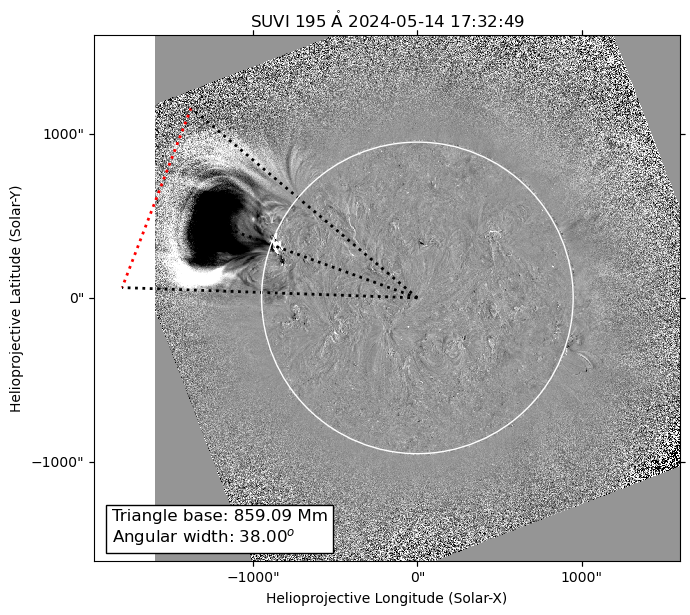

In [240]:
# Define the main parameters
central_angle = 160

upper_angle = central_angle - 20
lower_angle = central_angle + 18
central_line_length = 1450
m = suvi_seq_runratio[7]


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.grid(False)

# Get the start and end points of each line
_, upper_end   = myfuncs.plot_line(angle_deg=upper_angle, length=central_line_length+350, map_obj=m)
_, central_end = myfuncs.plot_line(angle_deg=central_angle, length=central_line_length, map_obj=m)
_, lower_end   = myfuncs.plot_line(angle_deg=lower_angle, length=central_line_length+350, map_obj=m)

# Compute the connecting line (perpendicular to central line)
connecting_line = SkyCoord([upper_end, lower_end])

# Compute the length of the connecting line in arcseconds
length_arcsec = np.sqrt((upper_end.Tx - lower_end.Tx)**2 + (upper_end.Ty - lower_end.Ty)**2)

# Convert arcseconds to megameters
solar_radius_Mm = const.radius.to('Mm').value
rsun_arcsec = m.rsun_obs.value  # Solar radius in arcseconds
length_Mm = (length_arcsec.value / rsun_arcsec) * solar_radius_Mm

# Compute the angular width (triangle head angle)
theta_deg = abs(upper_angle - lower_angle)

# Plot all lines
ax.plot_coord(SkyCoord([upper_end, lower_end]), color='red', linewidth=2, linestyle='dotted')  # Connecting line
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='black', linewidth=2, linestyle='dotted')
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), central_end]), color='black', linewidth=2, linestyle='dotted')  # Central line
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='black', linewidth=2, linestyle='dotted')

# Add the length text on the map
ax.text(0.03, 0.1, f'Triangle base: {length_Mm:.2f} Mm\nAngular width: {theta_deg:.2f}$^o$', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))

fig.tight_layout()
plt.show()

# dates_suvi.append(m.date)
# distances_suvi.append(length_Mm)
# angular_widths_suvi.append(theta_deg)

# dates_c2.append(m.date)
# distances_c2.append(length_Mm)
# angular_widths_c2.append(theta_deg)

# dates_c3.append(m.date)
# distances_c3.append(length_Mm)
# angular_widths_c3.append(theta_deg)

In [271]:
# Calc. the CME expansion speed
df_suvi = pd.DataFrame({'date': dates_suvi, 'length_Mm': distances_suvi, 'AW': angular_widths_suvi})
df_c2 = pd.DataFrame({'date': dates_c2, 'length_Mm': distances_c2, 'AW': angular_widths_c2})
df_c3 = pd.DataFrame({'date': dates_c3, 'length_Mm': distances_c3, 'AW': angular_widths_c3})

In [272]:
# Convert date column to datetime
df_suvi['date'] = pd.to_datetime(df_suvi['date'].apply(lambda t: t.iso))
df_c2['date'] = pd.to_datetime(df_c2['date'].apply(lambda t: t.iso))
df_c3['date'] = pd.to_datetime(df_c3['date'].apply(lambda t: t.iso))

In [273]:
def calc_speed(df):
    """
    Calculate the CME expansion speed in km/s.
    """
    speeds = []
    for i in range(1, len(df)):
        ds_Mm = (df.loc[i, 'length_Mm'] - df.loc[i - 1, 'length_Mm']) * u.Mm
        ds_km = ds_Mm.to('km').value  # Convert to km
        time_diff_sec = (df.loc[i, 'date'] - df.loc[i - 1, 'date']).total_seconds()
        vexp = ds_km / time_diff_sec
        speeds.append(vexp)
    return speeds

In [274]:
# Add expansion speed to the DataFrame (NaN for the first row)
expansion_speeds_suvi = calc_speed(df_suvi)
expansion_speeds_c2   = calc_speed(df_c2)
expansion_speeds_c3   = calc_speed(df_c3)

df_suvi['expansion_speed_km_s'] = [None] + expansion_speeds_suvi
df_c2['expansion_speed_km_s']   = [None] + expansion_speeds_c2
df_c3['expansion_speed_km_s']   = [None] + expansion_speeds_c3

In [275]:
display(df_suvi)
display(df_c2)
display(df_c3)

date   length_Mm  AW  expansion_speed_km_s
0 2024-05-14 17:24:49.569  309.594658  18                   NaN
1 2024-05-14 17:28:49.577  494.658145  26            771.072163
2 2024-05-14 17:32:49.589  859.090548  38           1518.392425

date    length_Mm  AW  expansion_speed_km_s
0 2024-05-14 17:48:07.566  1928.225522  52                   NaN
1 2024-05-14 18:00:07.457  3435.944154  62           2094.370720
2 2024-05-14 18:12:07.848  5179.234660  67           2419.922661

date     length_Mm  AW  expansion_speed_km_s
0 2024-05-14 18:18:09.644   6272.195436  68                   NaN
1 2024-05-14 19:18:07.601  14140.707112  81           2186.938775
2 2024-05-14 20:18:07.658  21777.169378  79           2121.205933

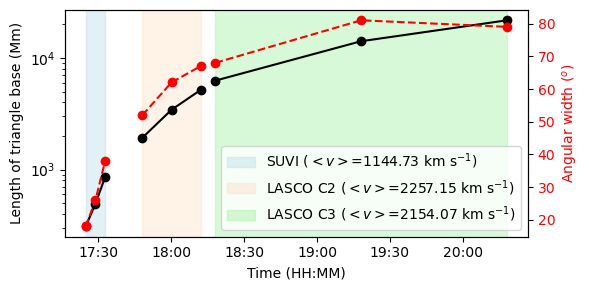

In [290]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111)

# Plot length in black
ax.plot(df_suvi['date'], df_suvi['length_Mm'], 'o-', color='k')
ax.plot(df_c2['date'], df_c2['length_Mm'], 'o-', color='k')
ax.plot(df_c3['date'], df_c3['length_Mm'], 'o-', color='k')
ax.set_ylabel('Length of triangle base (Mm)')
ax.set_xlabel('Time (HH:MM)')
ax.set_yscale('log')

# Make twin y-axis
ax2 = ax.twinx()
ax2.tick_params(axis='y', labelcolor='r')

# Plot AW in red dashed lines
ax2.plot(df_suvi['date'], df_suvi['AW'], 'o--', color='r')
ax2.plot(df_c2['date'], df_c2['AW'], 'o--', color='r')
ax2.plot(df_c3['date'], df_c3['AW'], 'o--', color='r')
ax2.set_ylabel(r'Angular width ($^o$)', color='r')

# Add vertical shading for each instrument
color_intensity = 0.35
ax.axvspan(df_suvi['date'].min(), df_suvi['date'].max(), color='#ADD8E6', alpha=color_intensity, label=rf'SUVI ($<v>$={np.nanmean(df_suvi["expansion_speed_km_s"]):.2f} km s$^{{-1}}$)')
ax.axvspan(df_c2['date'].min(), df_c2['date'].max(), color='#FFDAB9', alpha=color_intensity, label=rf'LASCO C2 ($<v>$={np.nanmean(df_c2["expansion_speed_km_s"]):.2f} km s$^{{-1}}$)')
ax.axvspan(df_c3['date'].min(), df_c3['date'].max(), color='#90EE90', alpha=color_intensity, label=rf'LASCO C3 ($<v>$={np.nanmean(df_c3["expansion_speed_km_s"]):.2f} km s$^{{-1}}$)')

ax.legend(loc='lower right')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.tight_layout()
fig.savefig(f'{data_dir}/cme_expansion_speed.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [142]:
# # Test ...
# ds_Mm = (3435.94 - 1928.23)*u.Mm
# ds_km = ds_Mm.to('km').value
# print(f'Distance difference: {ds_km:.2f} km')

# t1 = datetime.fromisoformat('2024-05-14T18:00:07.457')
# t2 = datetime.fromisoformat('2024-05-14T17:48:07.566')

# time_diff_sec = (t1 - t2).total_seconds()
# print(f'Time difference: {time_diff_sec:.2f} seconds')

# vexp = ds_km / time_diff_sec
# print(f'Expansion speed = {vexp:.2f} km/s')

Distance difference: 1507710.00 km
Time difference: 719.89 seconds
Expansion speed = 2094.36 km/s


In [325]:
def draw_triangle(map_obj=m, central_angle=160, upper_angle_shift=20, lower_angle_shift=18, central_line_length=1450):
    """
    Draws a triangular structure on a solar map by plotting three lines: a central line, an upper line, 
    and a lower line, each originating from a common starting point.

    Parameters:
    -----------
    map_obj : SunPy Map, optional
        The solar map object on which the triangle is drawn. Defaults to `m`.
    central_angle : float, optional
        The angle (in degrees) of the central line measured counterclockwise from the reference axis. 
        Defaults to 160 degrees.
    upper_angle_shift : float, optional
        The angular shift (in degrees) of the upper line relative to the central angle. Defaults to 20 degrees.
    lower_angle_shift : float, optional
        The angular shift (in degrees) of the lower line relative to the central angle. Defaults to 18 degrees.
    central_line_length : float, optional
        The length (in arcseconds) of the central line. Defaults to 1450 arcseconds.

    Returns:
    --------
    upper_end : SkyCoord
        The endpoint of the upper line in sky coordinates.
    lower_end : SkyCoord
        The endpoint of the lower line in sky coordinates.
    length_Mm : float
        The physical length of the connecting line between `upper_end` and `lower_end`, in megameters (Mm).
    theta_deg : float
        The angular width of the triangle (the angle between the upper and lower lines), in degrees.

    Notes:
    ------
    - The upper and lower lines extend beyond the central line by an additional 350 arcseconds.
    - The connecting line between the upper and lower endpoints is computed perpendicularly to the central line.
    - The function converts the connecting line's length from arcseconds to megameters based on the observed solar radius.

    """
    upper_angle = central_angle - upper_angle_shift
    lower_angle = central_angle + lower_angle_shift
    # Get the start and end points of each line
    _, upper_end   = myfuncs.plot_line(angle_deg=upper_angle, length=central_line_length+350, map_obj=m)
    _, central_end = myfuncs.plot_line(angle_deg=central_angle, length=central_line_length, map_obj=m)
    _, lower_end   = myfuncs.plot_line(angle_deg=lower_angle, length=central_line_length+350, map_obj=m)
    # Compute the connecting line (perpendicular to central line)
    connecting_line = SkyCoord([upper_end, lower_end])
    # Compute the length of the connecting line in arcseconds
    length_arcsec = np.sqrt((upper_end.Tx - lower_end.Tx)**2 + (upper_end.Ty - lower_end.Ty)**2)
    # Convert arcseconds to megameters
    solar_radius_Mm = const.radius.to('Mm').value
    rsun_arcsec = m.rsun_obs.value  # Solar radius in arcseconds
    length_Mm = (length_arcsec.value / rsun_arcsec) * solar_radius_Mm
    # Compute the angular width (triangle head angle)
    theta_deg = abs(upper_angle - lower_angle)
    return upper_end, lower_end, length_Mm, theta_deg

## Apply on a single map

2025-03-26 15:44:42 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:44:43 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


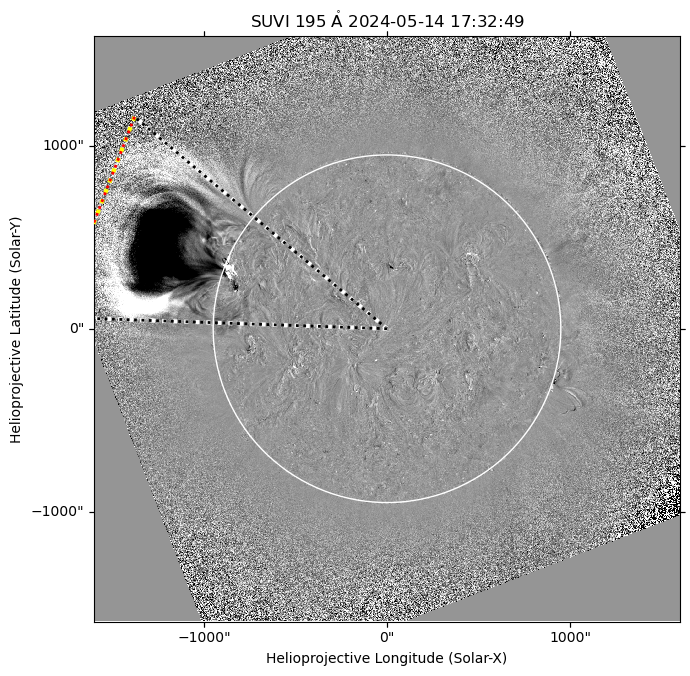

In [326]:
# Define the map and lines
m = suvi_seq_runratio[7]
upper_end, lower_end, length_Mm, theta_deg = draw_triangle(map_obj=m,
                                                           central_angle=160,
                                                           upper_angle_shift=20,
                                                           lower_angle_shift=18,
                                                           central_line_length=1450)


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.grid(False)

# Plot all lines
outline_wdith = 3
ax.plot_coord(SkyCoord([upper_end, lower_end]), color='yellow', linewidth=outline_wdith, linestyle=':')  # Outline (thicker)
ax.plot_coord(SkyCoord([upper_end, lower_end]), color='r', linewidth=2, linestyle=':')  # Connecting red (Main) line

ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='w', linewidth=outline_wdith, linestyle=':') # Outline (thicker)
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='k', linewidth=2, linestyle=':') # Main line

ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='w', linewidth=outline_wdith, linestyle=':') # Outline (thicker)
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='k', linewidth=2, linestyle=':')  # Main line

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
fig.tight_layout()
plt.show()

## Apply on several maps

In [ ]:
# Use these values for SUVI
# ==========================

# upper_angle = central_angle - 9
# lower_angle = central_angle + 9
# central_line_length = 1000
# m = suvi_seq_runratio[5]

# upper_angle = central_angle - 12
# lower_angle = central_angle + 14
# central_line_length = 1150
# m = suvi_seq_runratio[6]

# upper_angle = central_angle - 20
# lower_angle = central_angle + 18
# central_line_length = 1450
# m = suvi_seq_runratio[7]

# ======================================

# Use these values for LASCO C2
# ==============================

# upper_angle = central_angle - 26
# lower_angle = central_angle + 26
# central_line_length = 2650
# m = m_seq_runratio_c2[1]

# upper_angle = central_angle - 31
# lower_angle = central_angle + 31
# central_line_length = 4200
# m = m_seq_runratio_c2[2]

# upper_angle = central_angle - 32
# lower_angle = central_angle + 35
# central_line_length = 6050
# m = m_seq_runratio_c2[3]

# ======================================

# Use these values for LASCO C3
# ==============================

# upper_angle = central_angle - 34
# lower_angle = central_angle + 34
# central_line_length = 7300
# m = m_seq_runratio_c3[2]

# upper_angle = central_angle - 37
# lower_angle = central_angle + 44
# central_line_length = 14500
# m = m_seq_runratio_c3[7]

# upper_angle = central_angle - 35
# lower_angle = central_angle + 44
# central_line_length = 23000
# m = m_seq_runratio_c3[12]

In [329]:
map_params = {
    suvi_seq_runratio[5]: {'central_angle': 160, 'upper_angle_shift': 9, 'lower_angle_shift': 9, 'central_line_length': 1000},
    suvi_seq_runratio[6]: {'central_angle': 160, 'upper_angle_shift': 12, 'lower_angle_shift': 14, 'central_line_length': 1150},
    suvi_seq_runratio[7]: {'central_angle': 160, 'upper_angle_shift': 20, 'lower_angle_shift': 18, 'central_line_length': 1450},
    
    m_seq_runratio_c2[1]: {'central_angle': 160, 'upper_angle_shift': 26, 'lower_angle_shift': 26, 'central_line_length': 2650},
    m_seq_runratio_c2[2]: {'central_angle': 160, 'upper_angle_shift': 31, 'lower_angle_shift': 31, 'central_line_length': 4200},
    m_seq_runratio_c2[3]: {'central_angle': 160, 'upper_angle_shift': 32, 'lower_angle_shift': 35, 'central_line_length': 6050},
    
    m_seq_runratio_c3[2]: {'central_angle': 160, 'upper_angle_shift': 34, 'lower_angle_shift': 34, 'central_line_length': 7300},
    m_seq_runratio_c3[7]: {'central_angle': 160, 'upper_angle_shift': 37, 'lower_angle_shift': 44, 'central_line_length': 14500},
    m_seq_runratio_c3[12]: {'central_angle': 160, 'upper_angle_shift': 35, 'lower_angle_shift': 44, 'central_line_length': 23000},
}

2025-03-26 15:59:15 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:16 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:17 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:59:18 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:19 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-03-26 15:59:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


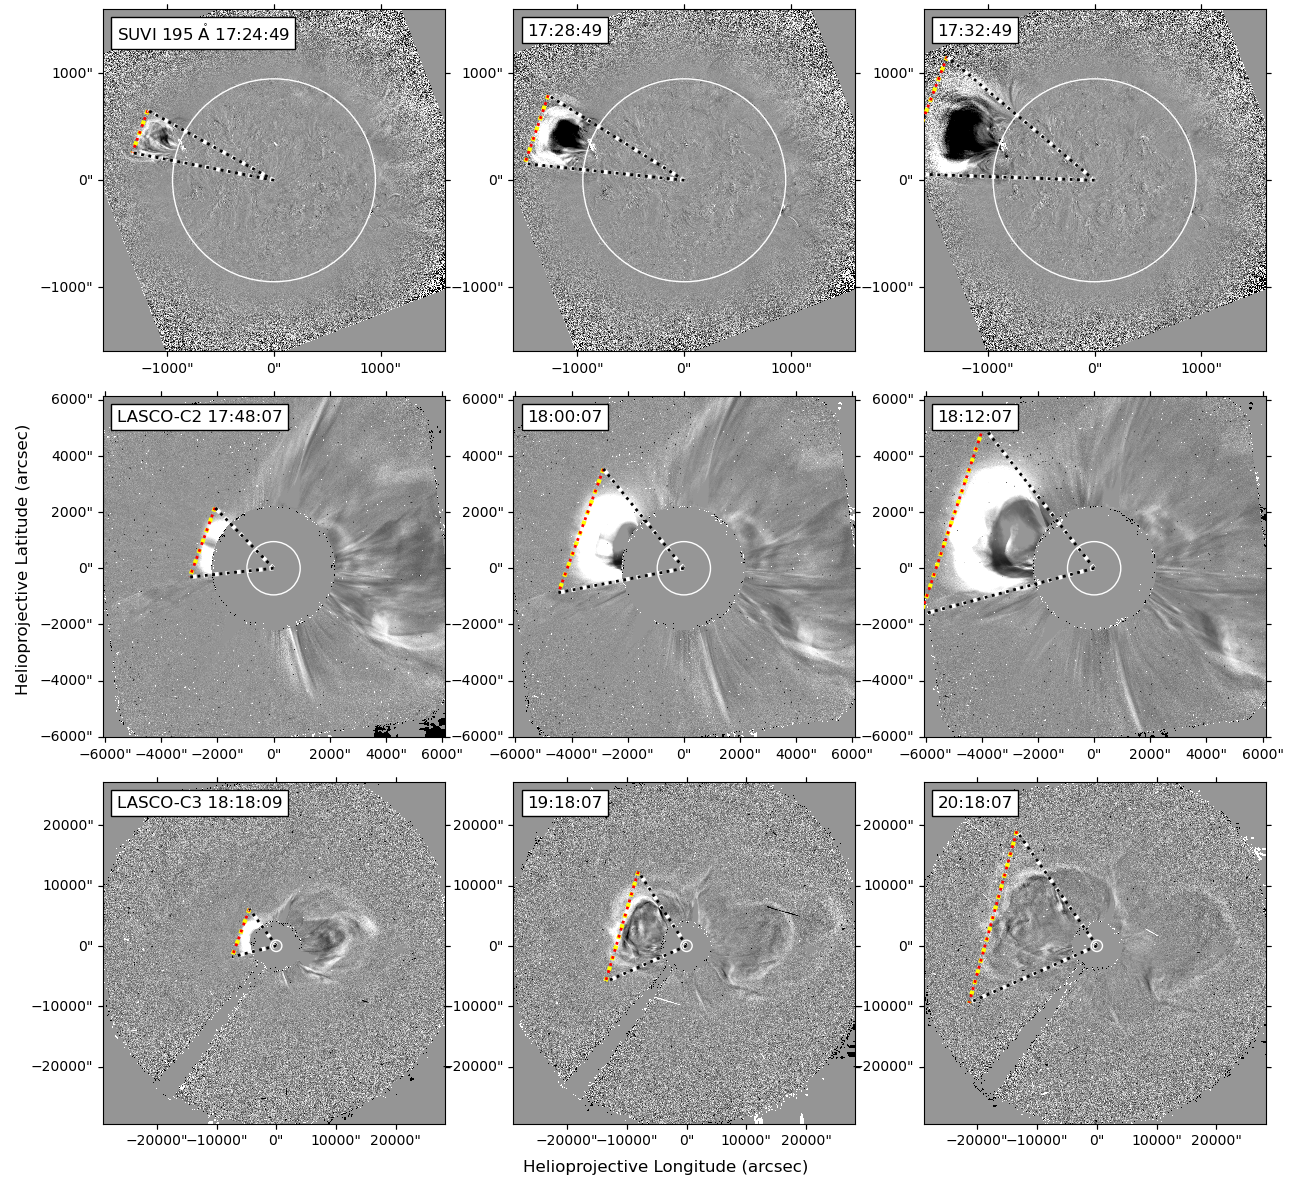

In [333]:
fig = plt.figure(figsize=[15,15])
fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.09)
fig.supylabel('Helioprojective Latitude (arcsec)', x=0.067)

for i, m in enumerate(subset):
    params = map_params[m]
    upper_end, lower_end, length_Mm, theta_deg = draw_triangle(map_obj=m,
                                                               central_angle=params['central_angle'],
                                                               upper_angle_shift=params['upper_angle_shift'],
                                                               lower_angle_shift=params['lower_angle_shift'],
                                                               central_line_length=params['central_line_length']
                                                              )
    
    ax = fig.add_subplot(3, 3, i+1, projection=m)
    m.plot(axes=ax)
    m.draw_limb()
    ax.grid(False)
    
    if i==0:
        label = m.latex_name.split(' 2024')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==1 or i==2:
        label = m.latex_name.split('2024-05-14 ')[-1]
    elif i==3:
        label = m.latex_name.split(' Orange')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==4 or i==5:
        label = m.latex_name.split('2024-05-14 ')[-1]
    elif i==6:
        label = m.latex_name.split(' Clear')[0] + ' ' + m.latex_name.split('2024-05-14 ')[-1]
    elif i==7 or i==8:
        label = m.latex_name.split('2024-05-14 ')[-1]
    ax.text(0.04, 0.96, label, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    
    # Plot all lines
    outline_wdith = 3
    ax.plot_coord(SkyCoord([upper_end, lower_end]), color='yellow', linewidth=outline_wdith, linestyle=':')  # Outline (thicker)
    ax.plot_coord(SkyCoord([upper_end, lower_end]), color='r', linewidth=2, linestyle=':')  # Connecting red (Main) line
    
    ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='w', linewidth=outline_wdith, linestyle=':') # Outline (thicker)
    ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='k', linewidth=2, linestyle=':') # Main line
    
    ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='w', linewidth=outline_wdith, linestyle=':') # Outline (thicker)
    ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='k', linewidth=2, linestyle=':')  # Main line
    
    ax.set_title('')
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

fig.subplots_adjust(wspace=0.2, hspace=0.01)  # Reduce whitespace
fig.savefig(f'{data_dir}/euv_runratio_panels.pdf', format='pdf', bbox_inches='tight')
plt.show()

2025-03-26 15:31:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-26 15:31:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


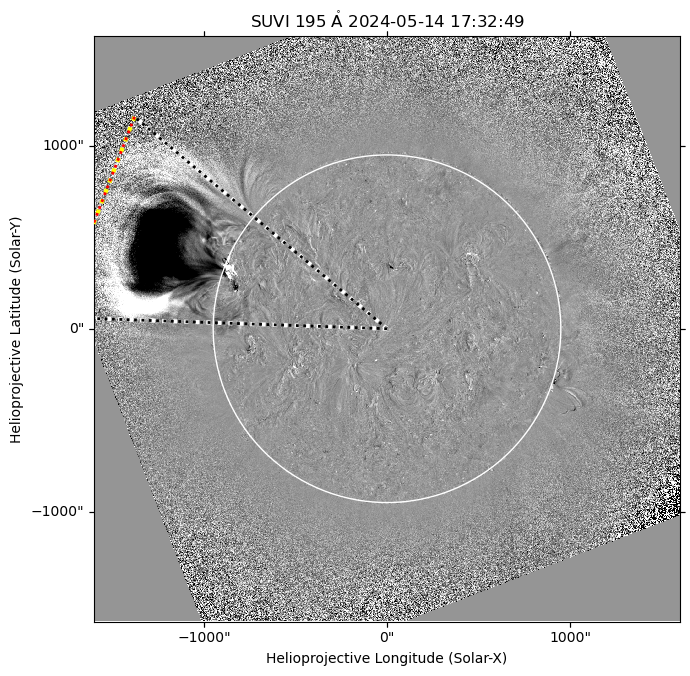

In [324]:
# Test ...

# Define the main parameters
central_angle = 160

upper_angle = central_angle - 20
lower_angle = central_angle + 18
central_line_length = 1450
m = suvi_seq_runratio[7]


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.grid(False)

# Get the start and end points of each line
_, upper_end   = myfuncs.plot_line(angle_deg=upper_angle, length=central_line_length+350, map_obj=m)
_, central_end = myfuncs.plot_line(angle_deg=central_angle, length=central_line_length, map_obj=m)
_, lower_end   = myfuncs.plot_line(angle_deg=lower_angle, length=central_line_length+350, map_obj=m)

# Compute the connecting line (perpendicular to central line)
connecting_line = SkyCoord([upper_end, lower_end])

# Compute the length of the connecting line in arcseconds
length_arcsec = np.sqrt((upper_end.Tx - lower_end.Tx)**2 + (upper_end.Ty - lower_end.Ty)**2)

# Convert arcseconds to megameters
solar_radius_Mm = const.radius.to('Mm').value
rsun_arcsec = m.rsun_obs.value  # Solar radius in arcseconds
length_Mm = (length_arcsec.value / rsun_arcsec) * solar_radius_Mm

# Compute the angular width (triangle head angle)
theta_deg = abs(upper_angle - lower_angle)

# Plot all lines
outline_wdith = 3

ax.plot_coord(SkyCoord([upper_end, lower_end]), color='yellow', linewidth=outline_wdith, linestyle=':')  # Outline (thicker)
ax.plot_coord(SkyCoord([upper_end, lower_end]), color='r', linewidth=2, linestyle=':')  # Connecting red (Main) line

ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='w', linewidth=outline_wdith, linestyle=':') # Outline (thicker)
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), upper_end]), color='k', linewidth=2, linestyle=':') # Main line

ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='w', linewidth=outline_wdith, linestyle=':') # Outline (thicker)
ax.plot_coord(SkyCoord([SkyCoord(0*u.arcsec, 0*u.arcsec, frame=m.coordinate_frame), lower_end]), color='k', linewidth=2, linestyle=':')  # Main line

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
fig.tight_layout()
plt.show()